<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

# 1.  Preferential Attachment

In [38]:
# estimating how ”rich” each vertices are by calculating the number of friends/neighbourhood (|Γ(x)|)

# reading graph using non_direction
directed_graph=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

# prfrential attachment of each user_i
def ps_attachment_single_user(a):
    try:
        preferential_score=len(set(directed_graph.successors(a)))
        return preferential_score      
    
    except:
        return -1

In [39]:
# reading graph using non_direction as inbuilt Netwotkx.preferential_attachment does not work on directed graph 
non_directed_graph=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)

# preferential_attachment for (u_i,u_j) using Netwotkx library to calculate preferential_attachment score
def ps_attachment(a,b):
    try:
        preferential_score=nx.preferential_attachment(non_directed_graph,[(a,b)])
        for s in preferential_score:
            return s[2]
        
    except:
        return -1


In [40]:
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

if not os.path.isfile('data/fea_sample/storage_sample_stage5.h5'):
    #===================================================================================================
    
    # preferential_attachment of source
    ps_attachment_source_train = df_final_train.apply(lambda row: ps_attachment_single_user(row['source_node']),axis=1)
    df_final_train["preferential_score_source"] = ps_attachment_source_train
    
    ps_attachment_source_test = df_final_test.apply(lambda row: ps_attachment_single_user(row['source_node']),axis=1)
    df_final_test["preferential_score_source"] = ps_attachment_source_test
    
    
    # preferential_attachment of destination
    ps_attachment_destination_train = df_final_train.apply(lambda row: ps_attachment_single_user(row['destination_node']),axis=1)
    df_final_train["preferential_score_destination"] = ps_attachment_destination_train
    
    ps_attachment_destination_test = df_final_test.apply(lambda row: ps_attachment_single_user(row['destination_node']),axis=1)
    df_final_test["preferential_score_destination"] = ps_attachment_destination_test
    
    
    # preferential_attachment_score by multiplying size neighbourhood of source and destination(using networkx library)
    preferential_score_source_destination_train = df_final_train.apply(lambda row:
                                                                       ps_attachment(row['source_node'],row['destination_node']),axis=1)
    df_final_train["preferential_score_source_destination"] = preferential_score_source_destination_train
    
    preferential_score_source_destination_test = df_final_test.apply(lambda row:
                                                                     ps_attachment(row['source_node'],row['destination_node']),axis=1)
    df_final_test["preferential_score_source_destination"] = preferential_score_source_destination_test
    
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage5.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
    
    #===================================================================================================

# 2. SVD  svd_dot  feature

In [44]:
# return the dot product of U,V.T --> SVD feature
def dot(a,b):
    return np.dot(a,b)


### 2.1 SVD Dot product of U,V.T on source node and destination node

In [46]:

df_final_train = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'test_df',mode='r')

if not os.path.isfile('data/fea_sample/storage_sample_stage6.h5'):
    #================================================================================================================  
    # applying dot product of U,V.T on source node and destination node
    
    df_final_train['source_U.VT']=df_final_train.apply(lambda row: dot(row[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
                                                                            'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']],
                                                                       row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3',
                                                                            'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]),axis=1)

    df_final_test['source_U.VT']=df_final_test.apply(lambda row: dot(row[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
                                                                          'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']],
                                                                     row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3',
                                                                          'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]),axis=1)


    df_final_train["destination_U.VT"] = df_final_train.apply(lambda row: dot(row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
                                                                                   'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']],
                                                                              row[['svd_v_d_1','svd_v_d_2', 'svd_v_d_3', 
                                                                                   'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]),axis=1)

    df_final_test["destination_U.VT"] = df_final_test.apply(lambda row: dot(row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
                                                                                 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']],
                                                                            row[['svd_v_d_1','svd_v_d_2', 'svd_v_d_3',
                                                                                 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage6.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
    
    #================================================================================================================

### 2.2 SVD Dot product of U,U.T  and V,V.T on  source and destination node

In [47]:
df_final_train = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'test_df',mode='r')

if not os.path.isfile('data/fea_sample/storage_sample_stage7.h5'):
    #================================================================================================================  
    # applying Dot product of U,U.T on source node and V,V.T on destination node
    
    df_final_train['source_destination_U.UT']=df_final_train.apply(lambda row: dot(row[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
                                                                            'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']],
                                                                               row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
                                                                            'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']]),axis=1)

    
    df_final_test['source_destination_U.UT']=df_final_test.apply(lambda row: dot(row[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
                                                                            'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']],
                                                                               row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
                                                                            'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']]),axis=1)


    df_final_train["source_destination_V.VT"] = df_final_train.apply(lambda row: dot(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3',
                                                                                    'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']],
                                                                              row[['svd_v_d_1','svd_v_d_2', 'svd_v_d_3', 
                                                                                   'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]),axis=1)

    df_final_test["source_destination_V.VT"] = df_final_test.apply(lambda row: dot(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3',
                                                                                    'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']],

                                                                              row[['svd_v_d_1','svd_v_d_2', 'svd_v_d_3', 
                                                                                   'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]),axis=1)
    hdf = HDFStore('data/fea_sample/storage_sample_stage7.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
    
    #================================================================================================================

## 3. Modeling

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage7.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage7.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_score_source', 'preferential_score_destination',
       'preferential_score_source_destination', 'source_U.VT'

In [4]:
df_final_train.shape

(100002, 61)

In [5]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_score_source,preferential_score_destination,preferential_score_source_destination,source_U.VT,destination_U.VT,source_destination_U.UT,source_destination_V.VT
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,6.616550e-14,9.771077e-13,4.159752e-14,16,10,187,2.069078e-11,1.206402e-12,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,6.738902e-02,2.607801e-11,2.372904e-09,84,168,20425,4.985937e-04,5.807276e-03,3.192812e-03,9.068719e-04
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-5.901864e-19,1.629341e-19,-2.572452e-19,50,35,2550,9.691382e-36,4.528636e-36,1.787503e-35,2.467873e-36
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,9.595823e-13,3.047045e-10,1.246592e-13,8,8,120,3.080648e-20,4.842891e-18,4.710376e-20,3.159386e-18
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,0.000000e+00,0.000000e+00,0.000000e+00,13,4,75,3.820391e-14,0.000000e+00,7.773952e-14,0.000000e+00


In [6]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [7]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## 3.1 RandomForestClassifier using various n_estimator parameter

Estimators =  10 Train Score 0.9160210656883666 test Score 0.8986979722518678
Estimators =  50 Train Score 0.9236173001310616 test Score 0.9206015353875276
Estimators =  100 Train Score 0.9239773429238517 test Score 0.9204208934534687
Estimators =  250 Train Score 0.9227762915900352 test Score 0.9185402684563759
Estimators =  450 Train Score 0.9221044726301736 test Score 0.917974471646788


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

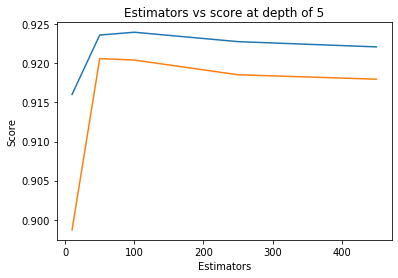

In [54]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8885341622734241 test Score 0.8729199472273056
depth =  9 Train Score 0.9586056644880175 test Score 0.9245207583696314
depth =  11 Train Score 0.9615954230995517 test Score 0.9248649671087199
depth =  15 Train Score 0.9637023225649549 test Score 0.9262246870010924
depth =  20 Train Score 0.963679995139782 test Score 0.9264041994750656
depth =  35 Train Score 0.963817854178056 test Score 0.9265067069714719
depth =  50 Train Score 0.963817854178056 test Score 0.9265067069714719
depth =  70 Train Score 0.963817854178056 test Score 0.9265067069714719
depth =  130 Train Score 0.963817854178056 test Score 0.9265067069714719


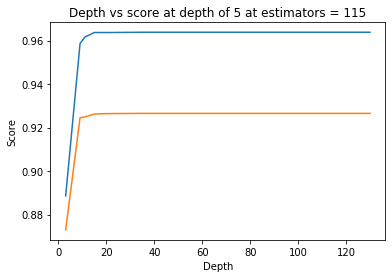

In [55]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

## 3.2 RandomForestClassifier hypertuning using RandonSearchCV

In [56]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25, return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96241759 0.96203769 0.9607686  0.96176077 0.96259747]
mean train scores [0.96287389 0.96265065 0.96118371 0.96245331 0.9634601 ]


In [57]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [58]:
#best hyperparameter after hypertuning
rf_random.best_params_

{'max_depth': 14,
 'min_samples_leaf': 28,
 'min_samples_split': 111,
 'n_estimators': 121}

In [59]:
# best score
rf_random.best_score_

0.9625974691596553

### 3.2.1 Traning using best hyperparameter

In [8]:
# traning using best hyperparameter
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [9]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [10]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9644600149855206
Test f1 score 0.9267012408927708


In [11]:
# utility function
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", annot_kws={"size": 15}, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f",annot_kws={"size": 15}, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt='.2f', annot_kws={"size": 15}, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


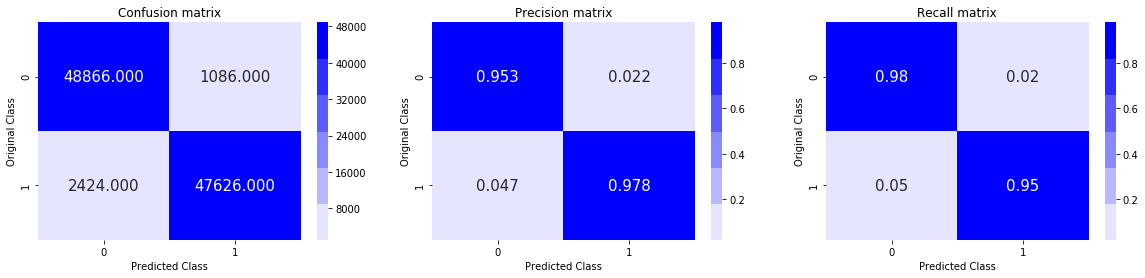

Test confusion_matrix


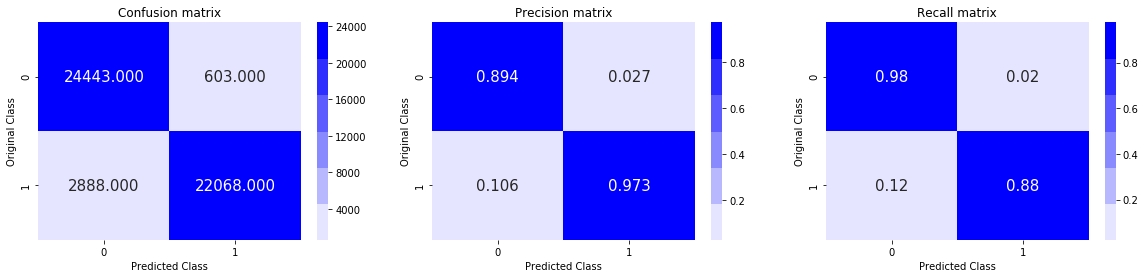

In [12]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

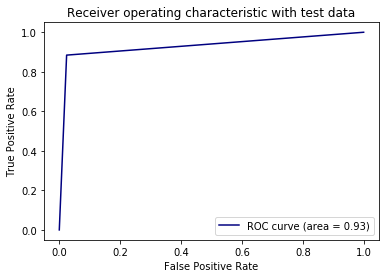

In [13]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

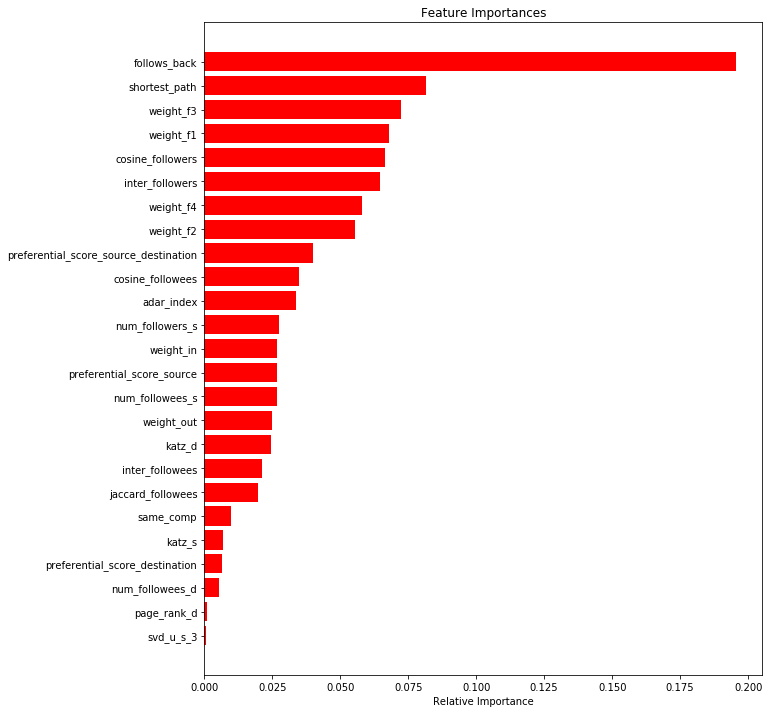

In [14]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 3.3 Xgboost hypertuning using RandonSearchCV

In [74]:
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":[10,25,50,100,150],
              "max_depth": [3,5,7,10,15,20,25],
              "learning_rate": [0.01,0.05,0.1,0.3,0.5]}

clf = xgb.XGBClassifier(random_state=25,n_jobs=-1)

gscv_xgboost = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=20, return_train_score=True)

gscv_xgboost.fit(df_final_train,y_train)

print('mean test scores',gscv_xgboost.cv_results_['mean_test_score'])
print('mean train scores',gscv_xgboost.cv_results_['mean_train_score'])

mean test scores [0.97275645 0.97191409 0.96317531 0.97369547 0.97616364]
mean train scores [0.97361705 0.97236247 0.96455085 0.97454971 0.99949719]


In [75]:
gscv_xgboost.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [78]:
#best hyperparameter after hypertuning
gscv_xgboost.best_params_

{'n_estimators': 10, 'max_depth': 25, 'learning_rate': 0.3}

In [79]:
# best score
gscv_xgboost.best_score_

0.9761636355560456

### 3.3.1 Traning using best hyperparameter

In [15]:
# traning using best hyperparameter
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [16]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [17]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9995604922486815
Test f1 score 0.9331087482892935


Train confusion_matrix


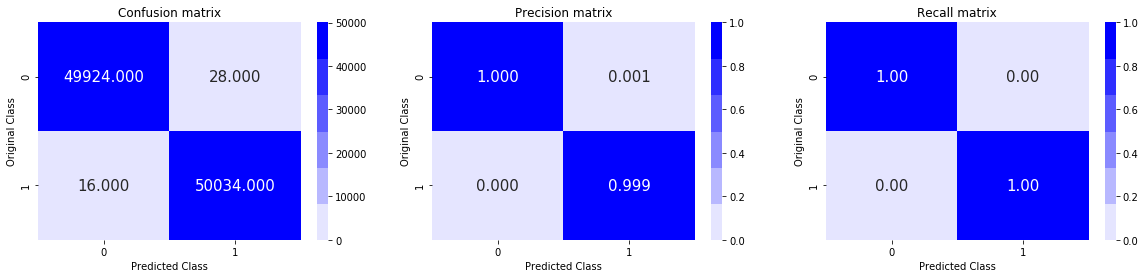

Test confusion_matrix


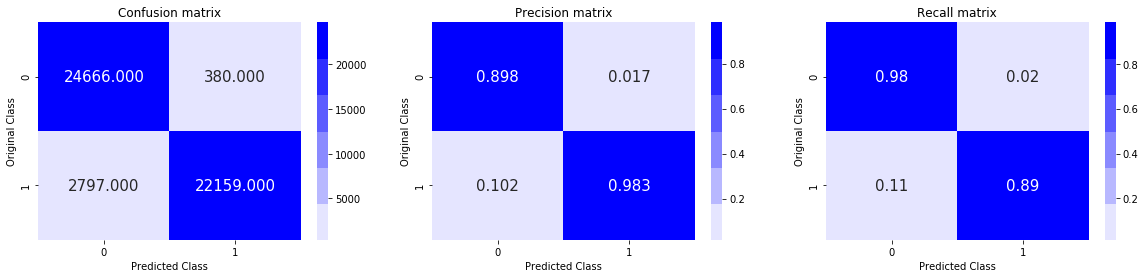

In [18]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

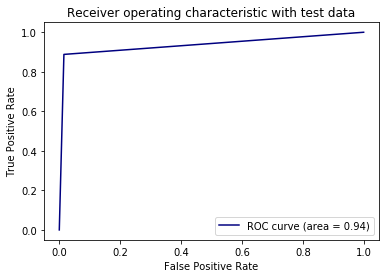

In [21]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

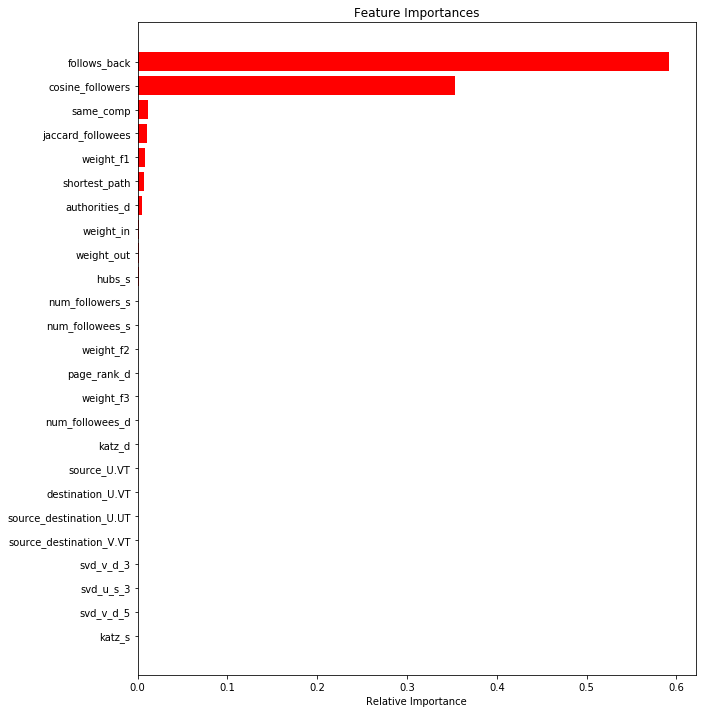

In [22]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 4. Conclusion

In [58]:
from prettytable import PrettyTable
# After adding prefrential_attachment and SVDdot feature
print("========Before adding prefrential_attachment and SVDdot feature========")
x=PrettyTable()
x.field_names = ["Model","train_f1_score","test_f1_score"]
x.add_row(["Random forest",0.965,0.924])
print(x)
print("="*70,"\n")

# After adding prefrential_attachment and SVDdot feature
print("========After adding prefrential_attachment and SVDdot feature========")
x=PrettyTable()
x.field_names = ["Model","train_f1_score","test_f1_score"]
x.add_row(["Random forest",0.964,0.926])
x.add_row(["Xgboost",0.999, 0.933])
print(x)
print("="*70)

========Before adding prefrential_attachment and SVDdot feature========
+---------------+----------------+---------------+
|     Model     | train_f1_score | test_f1_score |
+---------------+----------------+---------------+
| Random forest |     0.965      |     0.924     |
+---------------+----------------+---------------+

========After adding prefrential_attachment and SVDdot feature========
+---------------+----------------+---------------+
|     Model     | train_f1_score | test_f1_score |
+---------------+----------------+---------------+
| Random forest |     0.963      |     0.926     |
|    Xgboost    |      0.99      |     0.932     |
+---------------+----------------+---------------+


1. Although difference in result in RandomForest model is not much after adding prefrential_attachment and SVDdot feature, but feature importance of model is clearly showing  prefrential_attachment is an important feature


2. Using Xgboost with hyperparameter tuning  is giving best result among all.

        test_f1_score = 0.933 


## END:)